# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [14]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 100

# magic word for producing visualizations in notebook
%matplotlib inline

In [15]:
from IPython.display import display_html
def display_side_by_side(*args):
    # source: https://stackoverflow.com/a/44923103/6931113
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [16]:
from arvato_model.utils import *
from arvato_model.plot import *
from arvato_model.stats import *

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Load data
Read data as string first. Convert dtype on a need to basis.

In [17]:
# load in the data - force all data type to str
n_read_lines = 10000
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', nrows=n_read_lines, dtype=str)
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', nrows=n_read_lines, dtype=str)

## Data Type Conversion
1. `EINGEFUEGT_AM` is Date time YYYY-MM-DD HH:MM:SS
1. `OST_WEST_KZ` Can be re-endoded as 0, 1
1. Replace `X, XX` to `NA`

In [18]:
azdias.loc[:, 'EINGEFUEGT_AM'] = pd.to_datetime(azdias.loc[:, 'EINGEFUEGT_AM'], format='%Y-%m-%d %H:%M:%S')

In [19]:
# OST_WEST_KZ  (-1, O, W)
azdias.replace({'OST_WEST_KZ': {'O': '0', 'W': '1'}}, inplace=True)

In [20]:
azdias.replace(['X', 'XX'], pd.np.nan, inplace=True)

In [21]:
idx = ~azdias.columns.isin(['CAMEO_DEU_2015', 'EINGEFUEGT_AM', 'D19_LETZTER_KAUF_BRANCHE'])
azdias.iloc[:, idx] = azdias.iloc[:, idx].astype(float)

## Get meta data
Meta data does not have description for all the columns. Here we try to see which columns have been left out.

Perhaps we drop them from analysis?

In [22]:
meta_data = read_value_meta_data()

In [23]:
meta_data.head(5)

,Information level,Attribute,Description,Value,Meaning
0,Person,AGER_TYP,best-ager typology,-1,unknown
1,Person,AGER_TYP,best-ager typology,0,no classification possible
2,Person,AGER_TYP,best-ager typology,1,passive elderly
3,Person,AGER_TYP,best-ager typology,2,cultural elderly
4,Person,AGER_TYP,best-ager typology,3,experience-driven elderly


Understand which columns have not been covered by meta_data

In [24]:
# Common
with_meta_cols = set(meta_data.Attribute).intersection(set(azdias.columns))
len(with_meta_cols)

276

In [25]:
# Not described in meta_data
no_meta_cols = set(azdias.columns) - set(meta_data.Attribute)
len(no_meta_cols)

90

In [26]:
azdias.loc[:, no_meta_cols].head()

,D19_BILDUNG,KBA13_ANTG2,VK_DISTANZ,KBA13_ANTG4,RT_UEBERGROESSE,D19_BUCH_CD,VERDICHTUNGSRAUM,VHA,CJT_KATALOGNUTZER,UMFELD_ALT,...,STRUKTURTYP,CJT_TYP_6,KONSUMZELLE,D19_VERSAND_REST,D19_RATGEBER,ALTER_KIND4,D19_BEKLEIDUNG_REST,D19_BANKEN_REST,KBA13_GBZ,ANZ_KINDER
0,0.0,NaN,NaN,NaN,1.0,0.0,NaN,NaN,5.0,NaN,...,NaN,5.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN
1,0.0,4.0,11.0,1.0,5.0,0.0,0.0,0.0,1.0,3.0,...,2.0,1.0,1.0,0.0,0.0,NaN,0.0,0.0,4.0,0.0
2,6.0,3.0,9.0,0.0,5.0,0.0,1.0,0.0,2.0,2.0,...,3.0,2.0,0.0,0.0,0.0,NaN,0.0,0.0,4.0,0.0
3,0.0,3.0,10.0,0.0,3.0,6.0,0.0,1.0,3.0,4.0,...,1.0,3.0,0.0,0.0,0.0,NaN,0.0,0.0,4.0,0.0
4,6.0,4.0,5.0,1.0,5.0,6.0,1.0,0.0,3.0,4.0,...,3.0,3.0,0.0,2.0,0.0,NaN,1.0,6.0,3.0,0.0


## NA calues count

In [27]:
ROW_NA_PERC_THOLD = 20
COL_NA_PERC_THOLD = 20

In [28]:
col_na_summary = get_na_summary(azdias)
col_na_summary.head(5)

,na_count,na_perc
ALTER_KIND4,9991,99.91
ALTER_KIND3,9925,99.25
ALTER_KIND2,9709,97.09
ALTER_KIND1,9125,91.25
EXTSEL992,7404,74.04


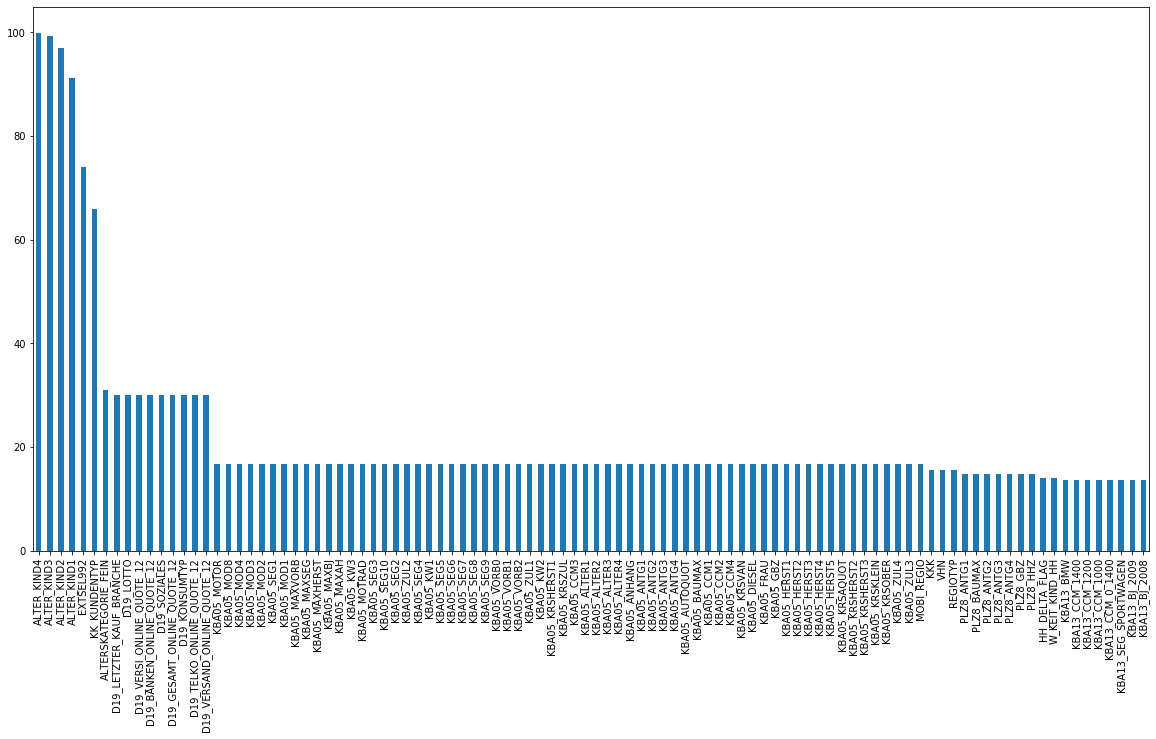

In [29]:
col_na_summary.loc[:, 'na_perc'].head(100).plot.bar(figsize=(20, 10));

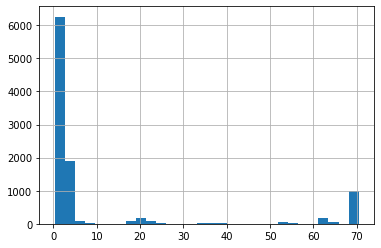

In [30]:
row_na_summary = get_na_summary(azdias, axis=1)
row_na_summary.head(5)
row_na_summary.loc[:, 'na_perc'].hist(bins=30)

## Missing values count

In [31]:
na_dict = get_values_missing(meta_data, sep=', ')

# if we need to convert this to string, int, float
na_dict = {key: [float(i) for i in val] for key, val in na_dict.items()}

# na_dict

In [32]:
missing_col_count_summary = get_values_missing_count(azdias, na_dict)

In [33]:
missing_col_count_summary.head(10)

,Attribute,missing_count,missing_perc
349,TITEL_KZ,8975,89.75
1,AGER_TYP,7658,76.58
129,KBA05_BAUMAX,3808,38.08
115,HEALTH_TYP,1432,14.32
346,SHOPPER_TYP,1432,14.32
354,VERS_TYP,1432,14.32
325,PRAEGENDE_JUGENDJAHRE,1406,14.06
314,NATIONALITAET_KZ,1400,14.00
360,W_KEIT_KIND_HH,473,4.73
326,REGIOTYP,427,4.27


In [34]:
# Replace the missing values as NA
azdias.replace(na_dict, pd.np.nan, inplace=True)

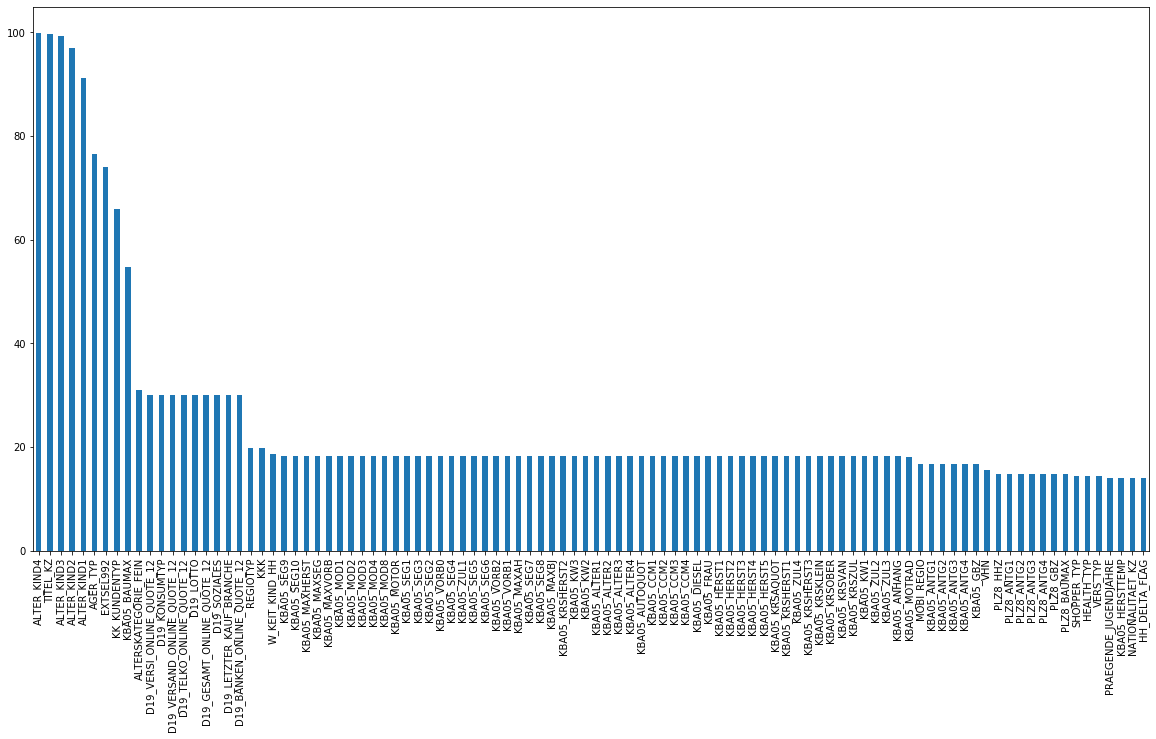

In [35]:
# Review how the NA distribution has changed in col and rows
col_na_summary = get_na_summary(azdias)
col_na_summary.loc[:, 'na_perc'].head(100).plot.bar(figsize=(20, 10));

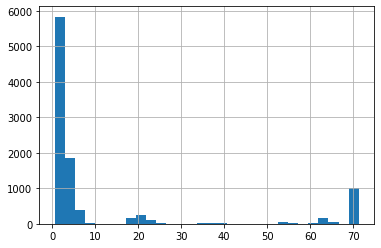

In [36]:
row_na_summary = get_na_summary(azdias, axis=1)
row_na_summary.loc[:, 'na_perc'].hist(bins=30)

## Clean NA

In [37]:
# Trim out columns that have more than 20% missing data.
cols_to_drop = col_na_summary.loc[col_na_summary.na_perc > COL_NA_PERC_THOLD, :].index

In [38]:
azdias.drop(list(cols_to_drop), axis=1, inplace=True)

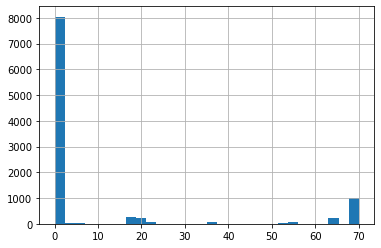

In [39]:
# Recalc row wise NA summary
row_na_summary = get_na_summary(azdias, axis=1)
row_na_summary.loc[:, 'na_perc'].hist(bins=30)

In [40]:
# Trim out rows that have more than 20% missing data.
rows_to_drop = row_na_summary.loc[row_na_summary.na_perc > ROW_NA_PERC_THOLD, :].index

In [41]:
azdias.drop(list(rows_to_drop), axis=0, inplace=True)

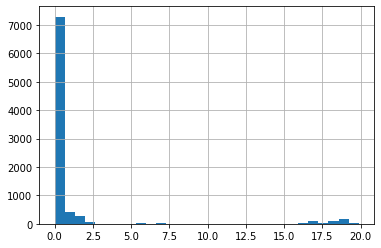

In [42]:
row_na_summary = get_na_summary(azdias, axis=1)
row_na_summary.loc[:, 'na_perc'].hist(bins=30)

## Check uniqueness and distribution

In [43]:
# Get the numb
col_uq = azdias.iloc[:, 1:].nunique()
col_uq                            

AKT_DAT_KL                9
ALTER_HH                 20
ANZ_HAUSHALTE_AKTIV     110
ANZ_HH_TITEL             10
ANZ_KINDER                5
                       ... 
WOHNDAUER_2008            9
WOHNLAGE                  8
ZABEOTYP                  6
ANREDE_KZ                 2
ALTERSKATEGORIE_GROB      5
Length: 346, dtype: int64

In [44]:
# Calculate the Simpsons and Shannon diversity index and get the Equivalence
simpson_idx = azdias.iloc[:, 1:].apply(simpson_diversity_index)
simpson_idx = simpson_idx/col_uq

shannon_idx = azdias.iloc[:, 1:].apply(shannon_diversity_index)
shannon_idx = shannon_idx/np.log(col_uq)

In [45]:
diversity_index = pd.DataFrame({'simpson': simpson_idx,
                                'shannon': shannon_idx})

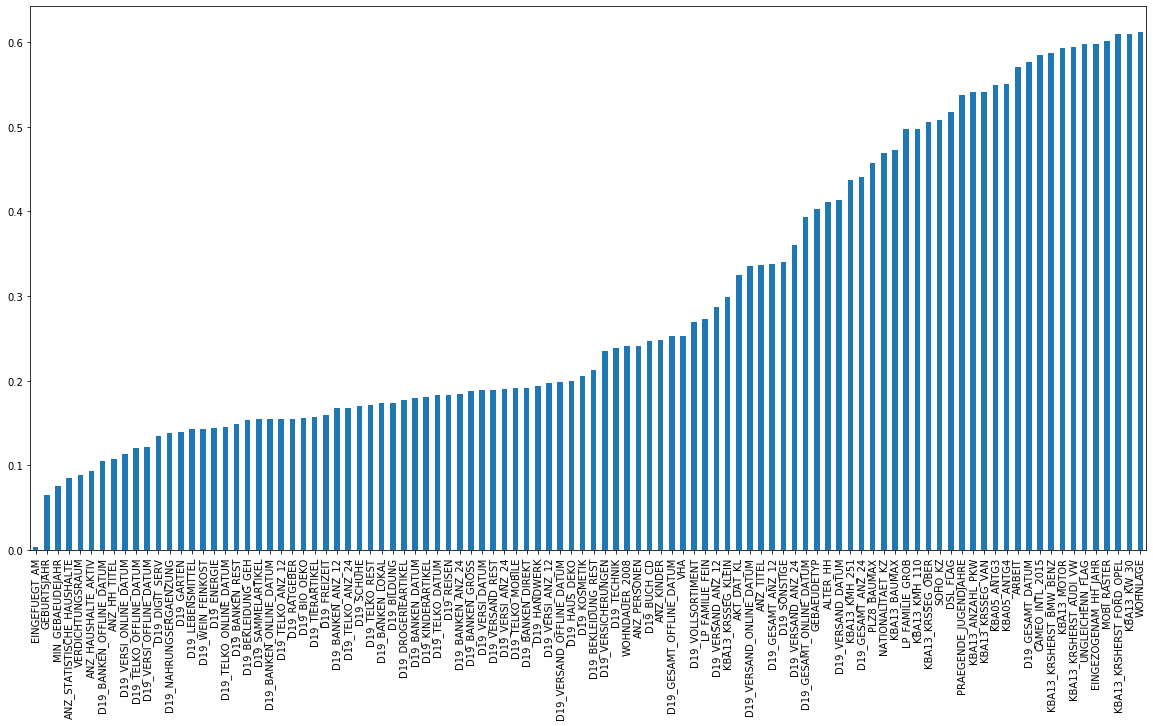

In [46]:
diversity_index.loc[:, 'simpson'].sort_values(ascending=True).head(100).plot.bar(figsize=(20, 10));

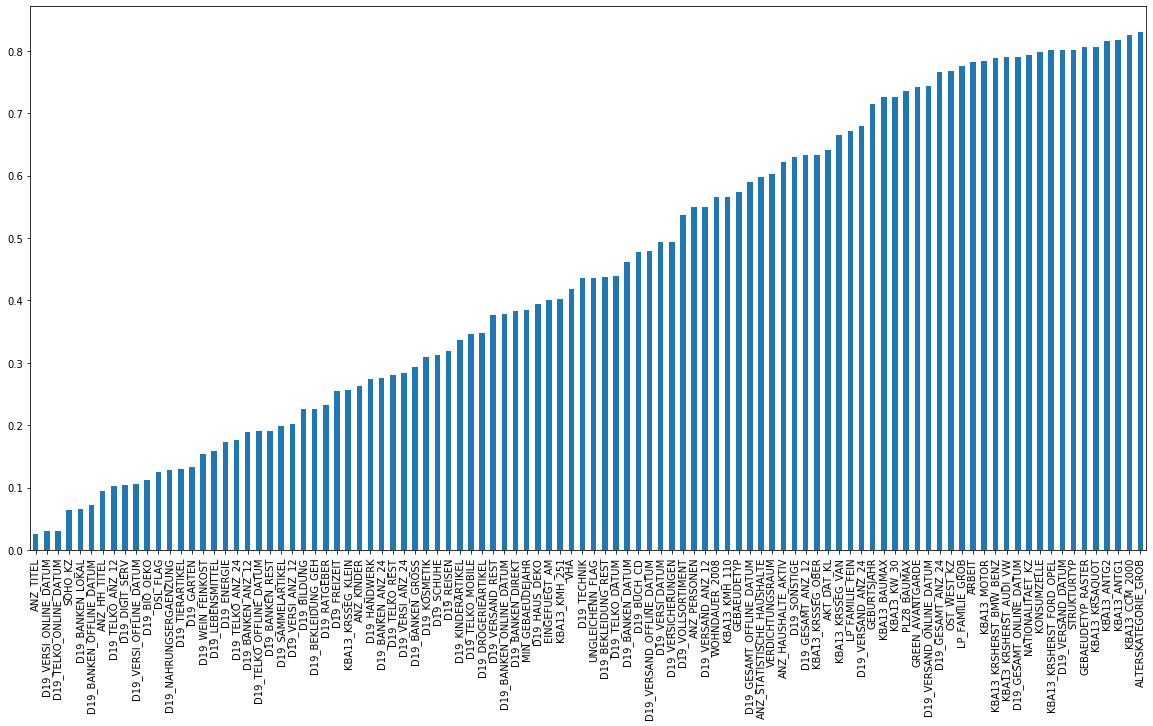

In [47]:
diversity_index.loc[:, 'shannon'].sort_values(ascending=True).head(100).plot.bar(figsize=(20, 10));

In [48]:
# Here we plot the value distribution by each col.
EQUIVALENCE_THRESHOLD = 0.5
low_div_col = diversity_index.loc[diversity_index.shannon<=EQUIVALENCE_THRESHOLD, :].index
idx = [list(azdias.columns).index(c) for c in low_div_col]
print('{} col have less than {} equivalence'.format(len(idx), EQUIVALENCE_THRESHOLD))

58 col have less than 0.5 equivalence


C:\Users\Pay1\Documents\Github\arvato_customer_segmentation\arvato_model\plot.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


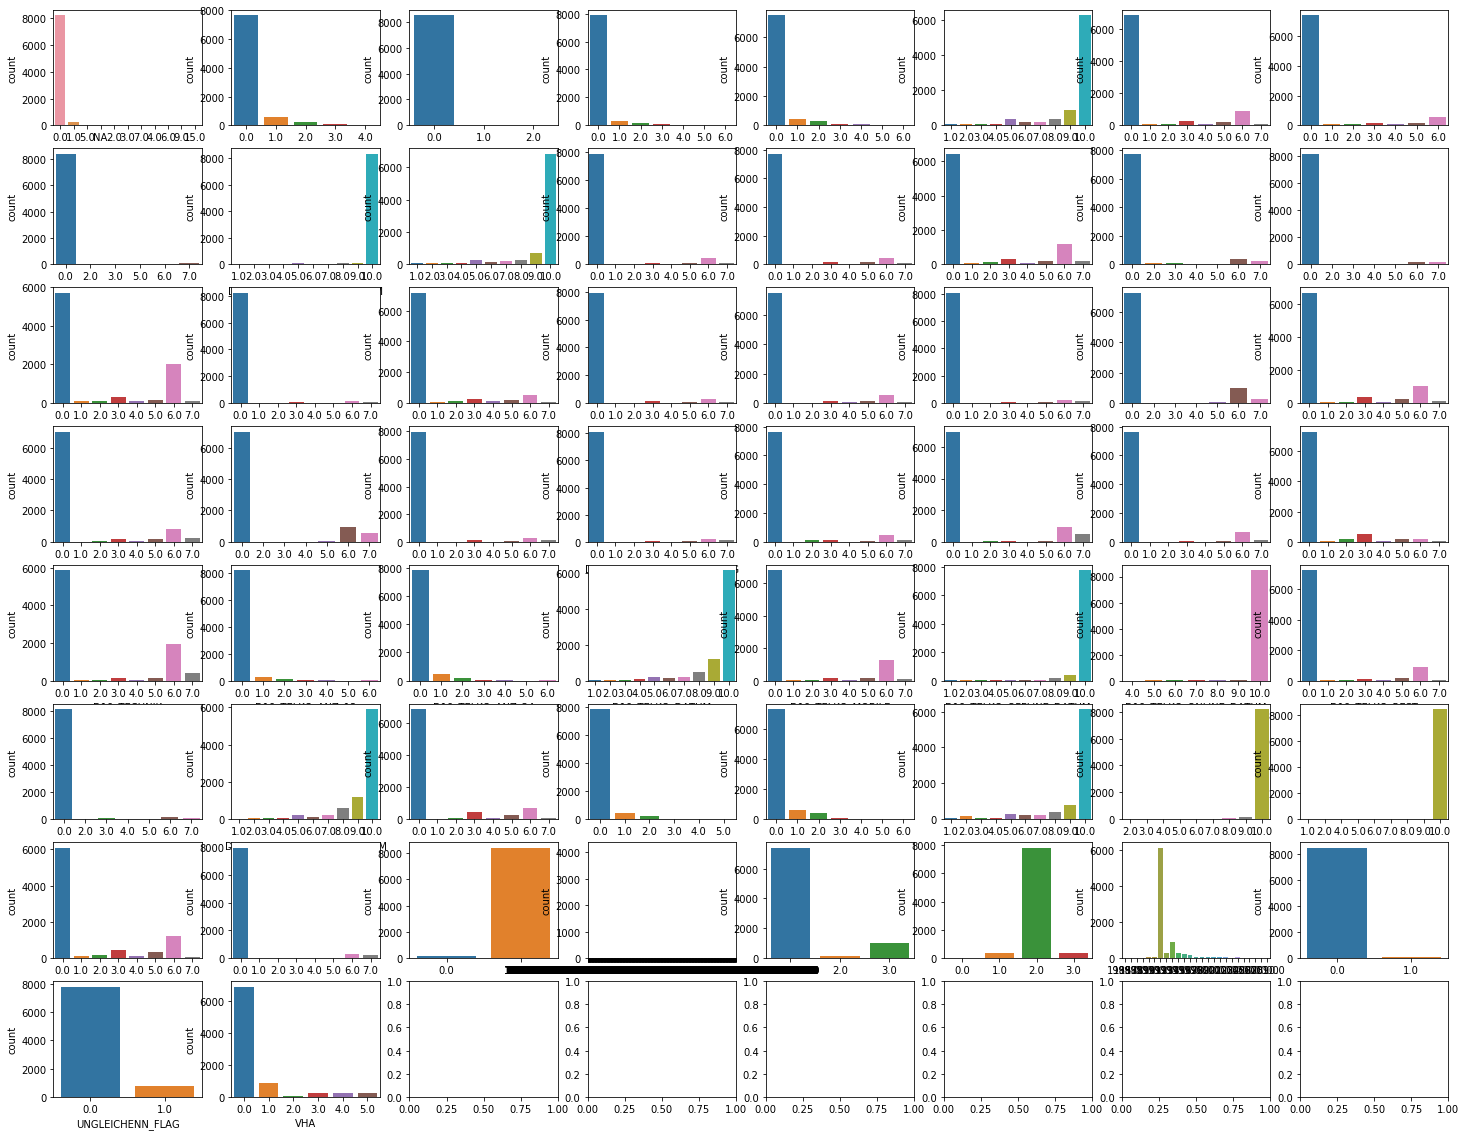

In [49]:
plot_data_dist(azdias, col_idx=idx, n_col=8, n_row=8)

In [50]:
# Drop the low diversity columns
azdias.drop(columns=low_div_col, inplace=True)

## See correlation

See the hierarchy dendrogram as well.

See correaltion within the levels.

Plot the scatter chart

In [51]:
idx = ~azdias.columns.isin(['CAMEO_DEU_2015', 'EINGEFUEGT_AM', 'LNR', 'D19_LETZTER_KAUF_BRANCHE'])
data_rank_corr = azdias.iloc[:, idx].astype(float).corr('spearman')

In [52]:
# plt.figure(figsize=(16, 16))
# mask = np.zeros_like(data_rank_corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True
# sns.heatmap(data_rank_corr, cmap='bwr', center=0, square=True, mask=mask);

In [53]:
# Set corr of less than 0.5 to 0 for the purpose of plotting.
CORR_THRESHOLD = 0.5
data_rank_corr_abs = data_rank_corr.abs()
data_rank_corr_abs.where(data_rank_corr_abs > CORR_THRESHOLD, 0, inplace=True)

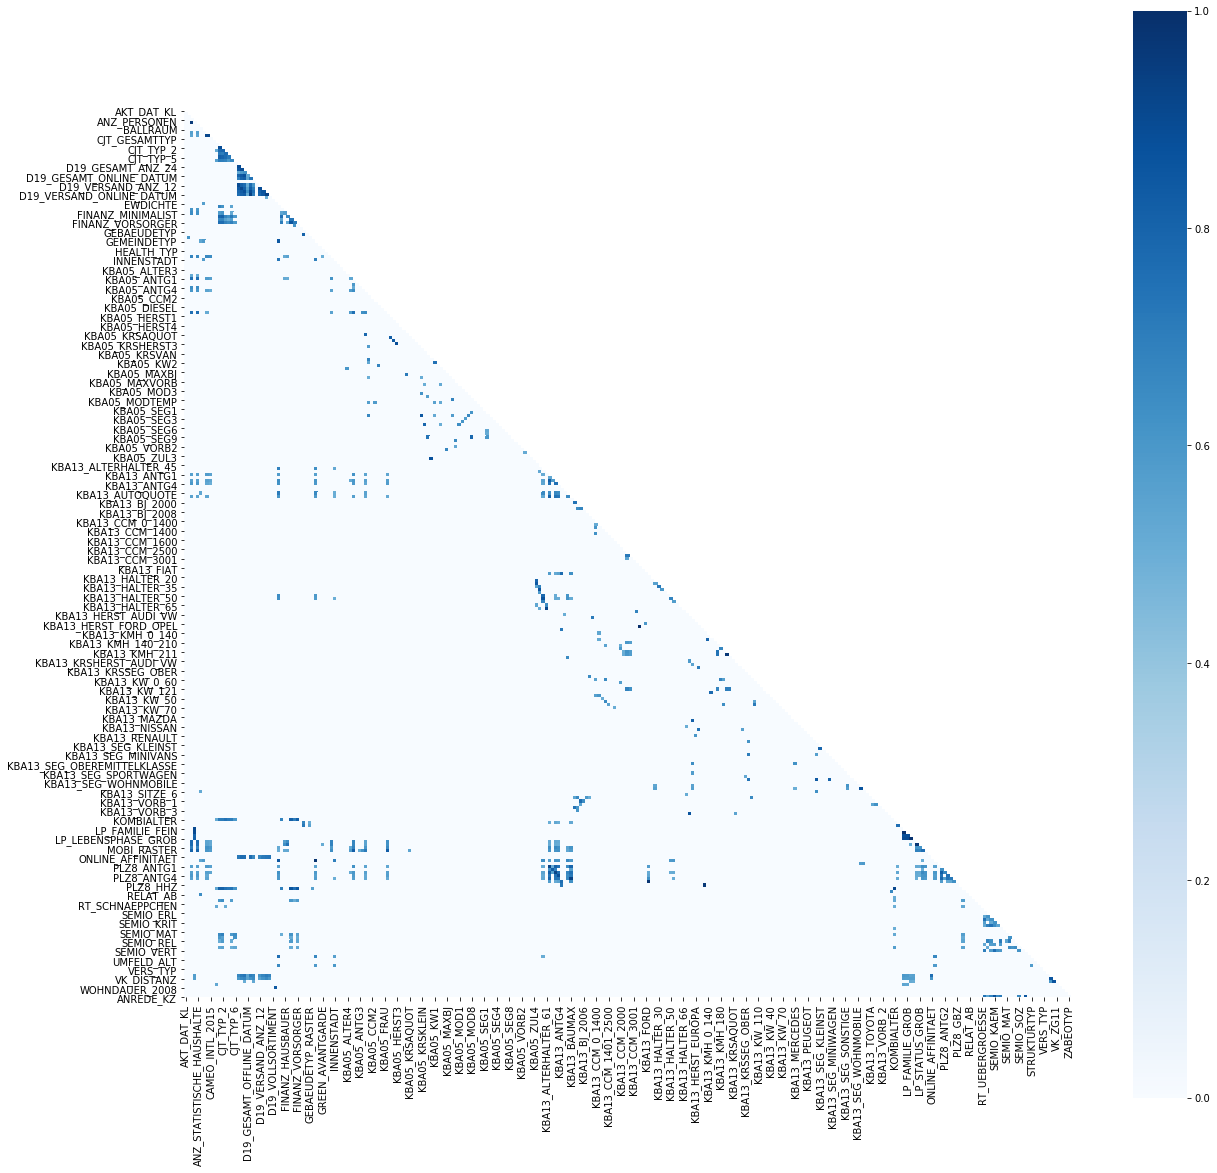

In [54]:
# Plot only those whose corr exceeds the threshold

# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
plt.figure(figsize=(20, 20))
mask = np.zeros_like(data_rank_corr_abs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data_rank_corr_abs, cmap='Blues', square=True, mask=mask);

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### One hot Encoding

Boolean columns that dont need one-hot encoding
* ANREDE_KZ
* BIP_FLAG
* GREEN_AVANTGARDE
* KBA05_SEG6
* OST_WEST_KZ
* VERS_TYP


In [ ]:
col_n_uq = azdias.nunique().sort_values(ascending=True)
col_n_uq[col_n_uq>10]

In [ ]:
# Look up columns in the values - 1-9  These can be one-hot encoded



## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')